In [12]:
def update_in_features(yaml_file, new_in_features, new_channel_num):
    updated_content = []
    with open(yaml_file, 'r') as file:
        for line in file:
            if 'in_features:' in line:
                updated_content.append(f'  in_features: {new_in_features}  # freq * channels = (n_fft // 2 + 1) * 16\n')
            elif 'ELECTRODE_CHANNELS:' in line:
                updated_content.append(f'  ELECTRODE_CHANNELS: {new_channel_num}\n')
            else:
                updated_content.append(line)
    with open(yaml_file, 'w') as file:
        file.writelines(updated_content)

def update_channels(yaml_file, new_channels):
    updated_content = []
    with open(yaml_file, 'r') as file:
        for line in file:
            if 'channels:' in line:
                updated_content.append(f'  channels: {new_channels}\n')
            else:
                updated_content.append(line)
    with open(yaml_file, 'w') as file:
        file.writelines(updated_content)
    
yaml_file = "config/model/tds_conv_ctc.yaml"
channels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
new_in_features = (64//2 + 1) * len(channels)
update_in_features(yaml_file, new_in_features, len(channels))

yaml_file = "config/transforms/log_spectrogram.yaml"
channels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
update_channels(yaml_file, channels)

In [13]:
channelList = [channels]
for i in [2, 3, 4, 6, 12]:
  channelList.append(channels[::i])
channelList.append(channels[0:1])
channelList.append(channels[:8])
channelList.append(channels[8:])

In [14]:
channelList

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [0, 2, 4, 6, 8, 10, 12, 14],
 [0, 3, 6, 9, 12, 15],
 [0, 4, 8, 12],
 [0, 6, 12],
 [0, 12],
 [0],
 [0, 1, 2, 3, 4, 5, 6, 7],
 [8, 9, 10, 11, 12, 13, 14, 15]]

In [17]:
for i in range(len(channelList)):
  new_channels = channelList[i]
  update_channels("config/transforms/log_spectrogram.yaml", new_channels)
  new_in_features = (64//2 + 1) * len(new_channels)
  update_in_features("config/model/tds_conv_ctc.yaml", new_in_features, len(new_channels))
  !python -m emg2qwerty.train \
    user="single_user" \
    trainer.accelerator=gpu trainer.devices=1 \
    --multirun

[2025-03-07 18:07:28,098][HYDRA] Submitit 'local' sweep output dir : logs/2025-03-07/18-07-28
[2025-03-07 18:07:28,099][HYDRA] 	#0 : user=single_user trainer.accelerator=gpu trainer.devices=1
[2025-03-07 18:16:35,967][HYDRA] Submitit 'local' sweep output dir : logs/2025-03-07/18-16-35
[2025-03-07 18:16:35,968][HYDRA] 	#0 : user=single_user trainer.accelerator=gpu trainer.devices=1
[2025-03-07 18:24:40,513][HYDRA] Submitit 'local' sweep output dir : logs/2025-03-07/18-24-40
[2025-03-07 18:24:40,514][HYDRA] 	#0 : user=single_user trainer.accelerator=gpu trainer.devices=1
[2025-03-07 18:32:24,893][HYDRA] Submitit 'local' sweep output dir : logs/2025-03-07/18-32-24
[2025-03-07 18:32:24,894][HYDRA] 	#0 : user=single_user trainer.accelerator=gpu trainer.devices=1
[2025-03-07 18:39:54,850][HYDRA] Submitit 'local' sweep output dir : logs/2025-03-07/18-39-54
[2025-03-07 18:39:54,851][HYDRA] 	#0 : user=single_user trainer.accelerator=gpu trainer.devices=1
[2025-03-07 18:47:16,457][HYDRA] Submiti

In [34]:
import os
import ast 
import shutil

main_dir = 'logs/2025-03-07'

subdirs = sorted(os.listdir(main_dir), reverse=False)
paths = []
for subdir in subdirs:
    subdir_path = os.path.join(main_dir, subdir)
    if os.path.isdir(subdir_path):
        job0_dir = None
        for folder in os.listdir(subdir_path):
            if folder.startswith('job0'):
                job0_dir = os.path.join(subdir_path, folder)
                break
        
        if job0_dir and os.path.isdir(job0_dir):
            checkpoints_dir = os.path.join(job0_dir, 'checkpoints')
            if os.path.isdir(checkpoints_dir):
                for file in os.listdir(checkpoints_dir):
                    if file.startswith('epoch'):
                        epoch_file_path = os.path.join(checkpoints_dir, file)
                        paths.append(str(epoch_file_path))
                        break


for i in range(len(channelList)):
    src = paths[i]
    dest_dir = 'channel_logs'
    os.makedirs(dest_dir, exist_ok=True)
    dest_file = os.path.join(dest_dir, f'{i+1}.ckpt')
    shutil.copy(src, dest_file)

def loss_and_CER(result):
  output = result.stdout
  start_index = output.find("'test_metrics': [")
  test_metrics = output[start_index:]
  end_index = test_metrics.find("'best_checkpoint': ''}")
  test_metrics = test_metrics[:end_index-3]

  test_metrics = test_metrics.replace("'", "\"")
  test_metrics = "{" + test_metrics + "}"
  try:
      test_metrics_dict = ast.literal_eval(test_metrics)
  except SyntaxError as e:
      print(f"Error parsing the string: {e}")
  return test_metrics_dict['test_metrics'][0]['test/loss'], test_metrics_dict['test_metrics'][0]['test/CER']

In [35]:
import subprocess

loss_list = []
CER_list = []
for i in range(len(channelList)):
    new_channels = channelList[i]
    update_channels("config/transforms/log_spectrogram.yaml", new_channels)
    new_in_features = (64//2 + 1) * len(new_channels)
    update_in_features("config/model/tds_conv_ctc.yaml", new_in_features, len(new_channels))
    result = subprocess.run(
        f"python -m emg2qwerty.train user='single_user' checkpoint='channel_logs/{i+1}.ckpt' train=False trainer.accelerator=gpu decoder=ctc_greedy hydra.launcher.mem_gb=64",
        shell=True,
        capture_output=True,
        text=True
    )
    loss, CER = loss_and_CER(result)
    loss_list.append(loss)
    CER_list.append(CER)

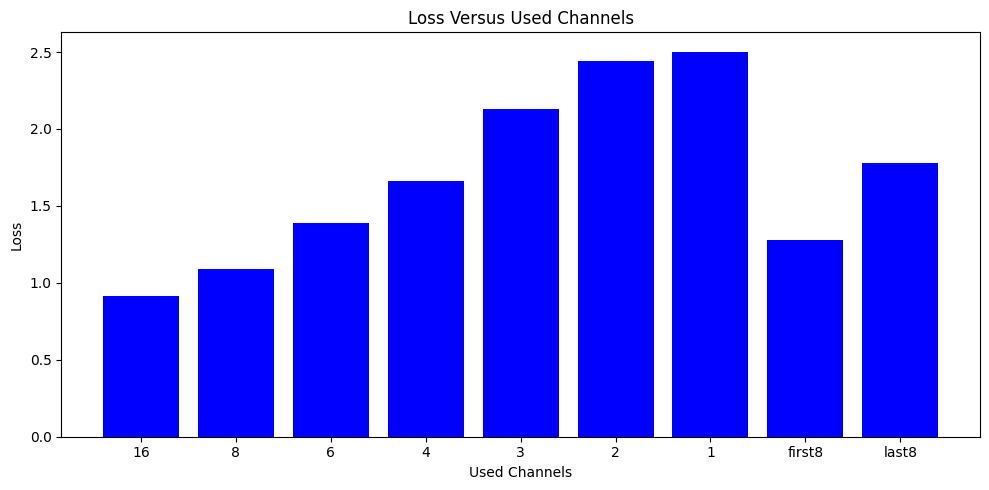

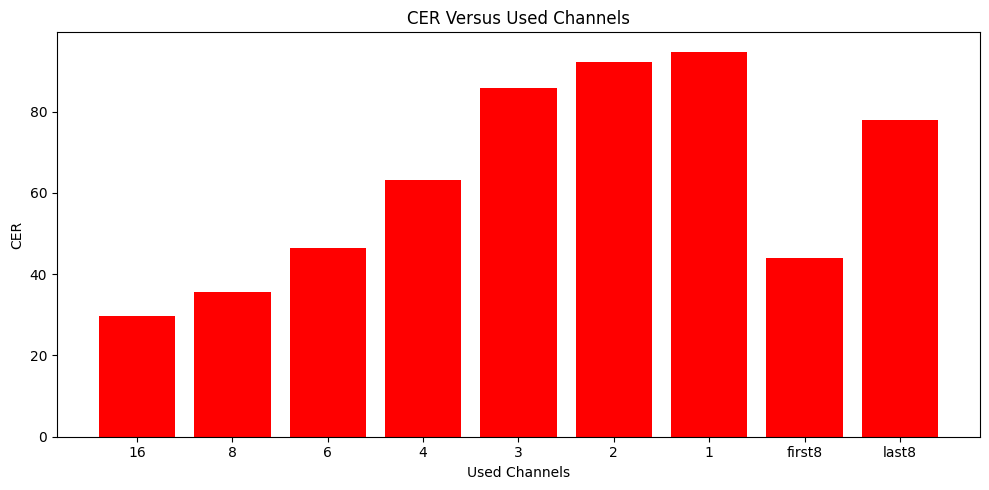

In [36]:
import matplotlib.pyplot as plt

custom_xticklabels = ["16", "8", "6", "4", "3", "2", "1", "first8", "last8"]

durationList = range(len(channelList))

# Column plot for Loss
plt.figure(figsize=(10, 5))
plt.bar(durationList, loss_list, color='b', label='Loss')  # Using bar instead of plot
plt.title('Loss Versus Used Channels')
plt.xlabel('Used Channels')
plt.ylabel('Loss')
plt.xticks(durationList, custom_xticklabels) 
plt.tight_layout()

plt.savefig('loss_vs_channels.png', format='png') 
plt.savefig('loss_vs_channels.svg', format='svg') 
plt.show()

# Column plot for CER
plt.figure(figsize=(10, 5))
plt.bar(durationList, CER_list, color='r', label='CER')
plt.title('CER Versus Used Channels')
plt.xlabel('Used Channels')
plt.ylabel('CER')
plt.xticks(durationList, custom_xticklabels) 
plt.tight_layout()

plt.savefig('cer_vs_channels.png', format='png') 
plt.savefig('cer_vs_channels.svg', format='svg')  
plt.show()
